             Stock
count   248.000000
mean   1545.911895
std     156.375082
min    1190.340000
25%    1429.807500
50%    1552.115000
75%    1641.837500
max    1921.920000


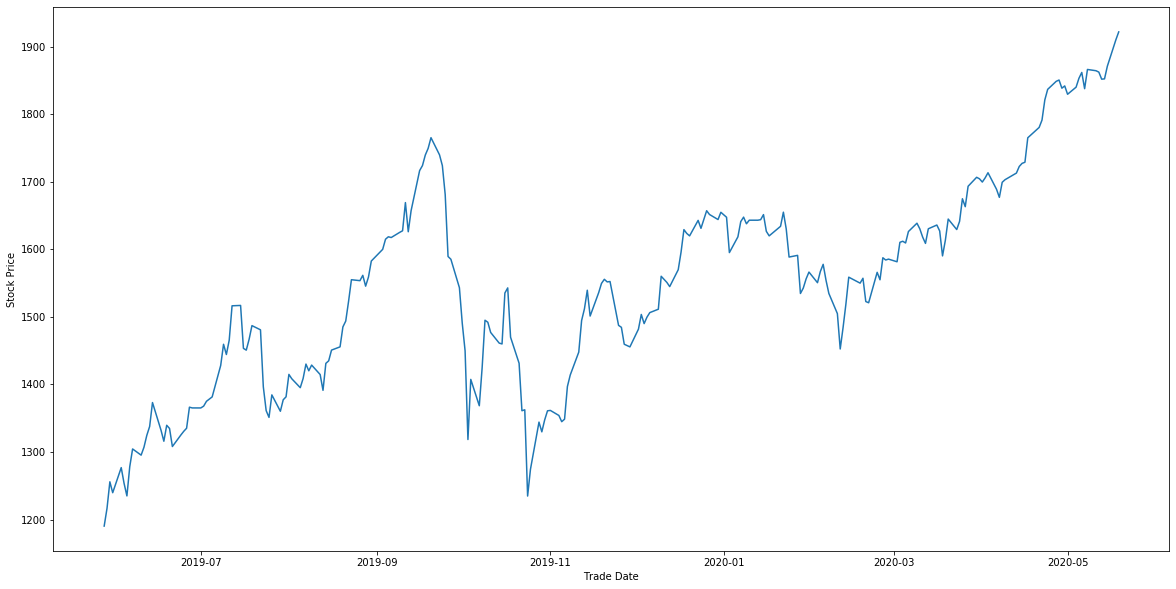

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split

df = pd.read_csv('sample_ts.csv', parse_dates=['Date'], index_col=['Date'])
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)
print(df.describe())

plt.figure(figsize=(20,10))
plt.xlabel('Trade Date')
plt.ylabel('Stock Price')
plt.plot(df)
plt.show()

In [142]:
def test_stationarity(ts, window):
    roll_mean = ts.rolling(window=window).mean()
    roll_std = ts.rolling(window=window).std()
    plt.figure(figsize=(20,10))
    plt.plot(ts, label='raw')
    plt.plot(roll_mean,label='rolling mean')
    plt.plot(roll_std, label='rolling std')
    plt.legend(loc='best')
    plt.title('raw vs rolling mean vs rolling std')
    plt.show()

    result = adfuller(ts['Stock'])
    print('ADF: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('critical values:')
    for key, value in result[4].items():
        print('{}: {}'.format(key, value))
    if result[0]> result[4]['5%']:
        print("has unit roots, non stationary")
    else:
        print("no unit roots, stationary")

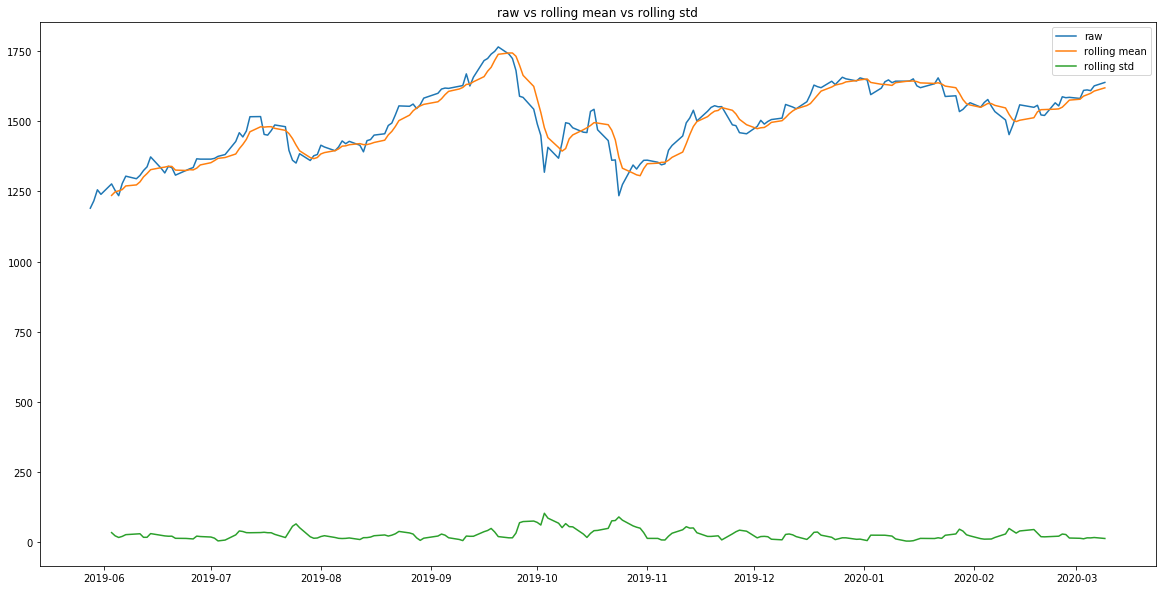

ADF: -2.4852567276506026
p-value: 0.11910285573068724
critical values:
1%: -3.463987334463603
5%: -2.8763259091636213
10%: -2.5746515171738515
has unit roots, non stationary


In [143]:
window = 5
test_stationarity(train_df, window=window)

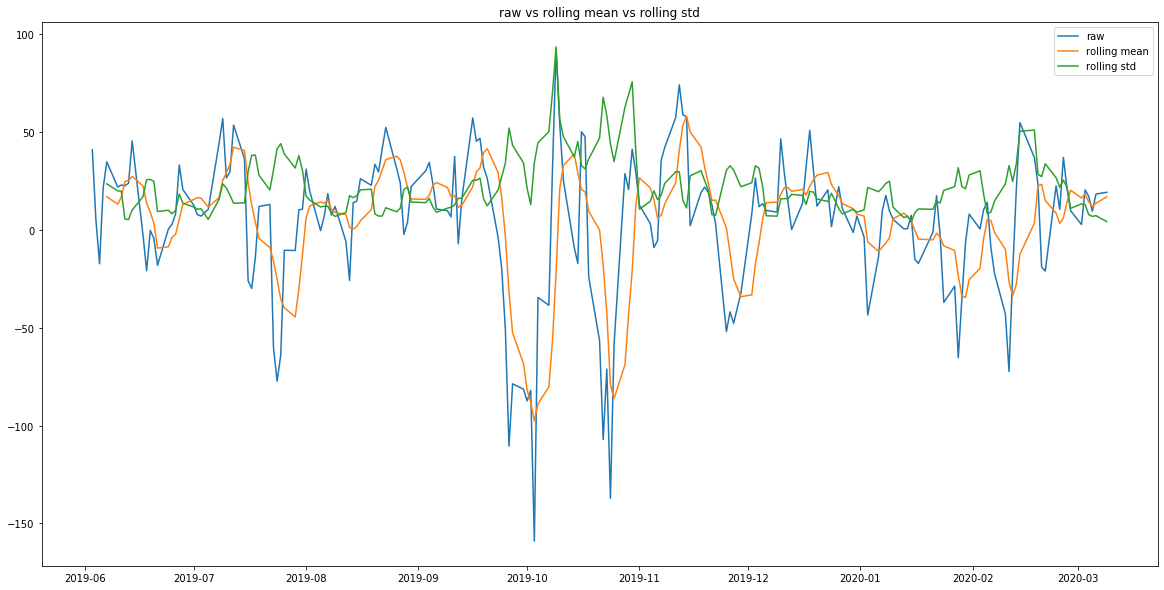

ADF: -5.003148097033821
p-value: 2.1876963839422136e-05
critical values:
1%: -3.465620397124192
5%: -2.8770397560752436
10%: -2.5750324547306476
no unit roots, stationary


In [144]:
rolling_mean = train_df.rolling(window=window).mean()
df_sma = train_df - rolling_mean
df_sma.dropna(inplace=True)

test_stationarity(df_sma, window)

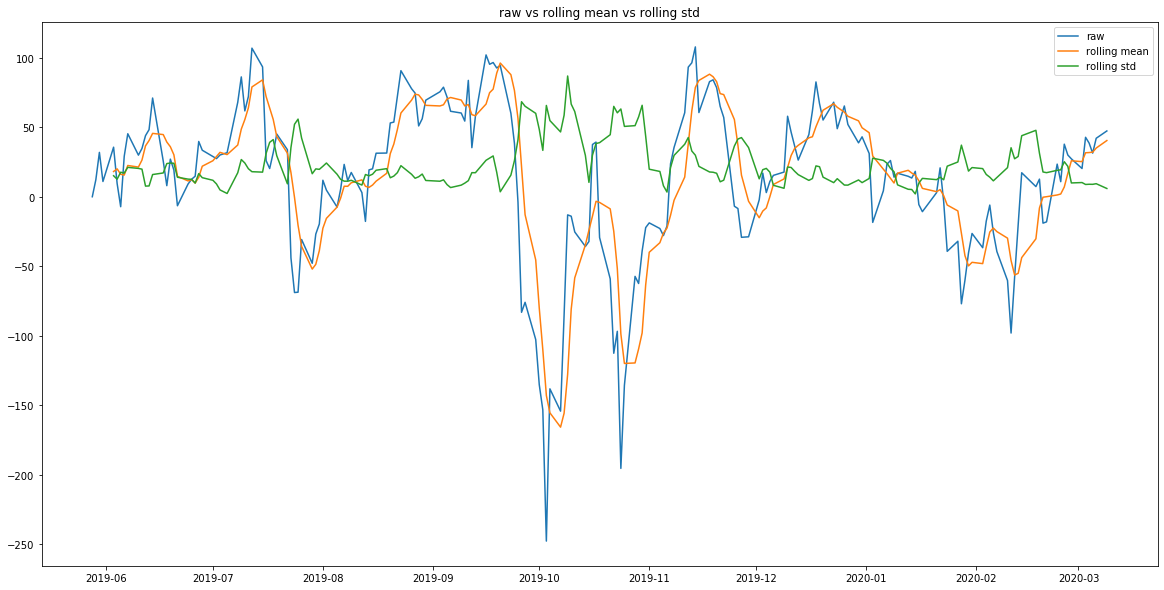

ADF: -3.5218276599493494
p-value: 0.007443893268712038
critical values:
1%: -3.463987334463603
5%: -2.8763259091636213
10%: -2.5746515171738515
no unit roots, stationary


In [145]:
rolling_mean_exp = train_df.ewm(halflife=window).mean()
df_ema = train_df - rolling_mean_exp
df_ema.dropna(inplace=True)
test_stationarity(df_ema, window)

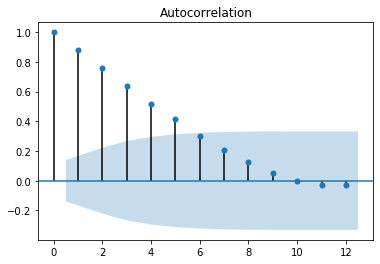

In [146]:
plot_acf(df_ema, lags=12);

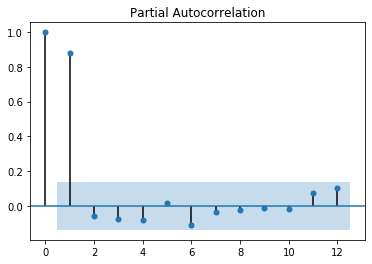

In [147]:
plot_pacf(df_ema, lags=12);

/Users/nikkatalnikov/opt/anaconda3/envs/kpi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/nikkatalnikov/opt/anaconda3/envs/kpi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/nikkatalnikov/opt/anaconda3/envs/kpi/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/nikkatalnikov/opt/anaconda3/envs/kpi/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp

                             ARIMA Model Results                              
Dep. Variable:                D.Stock   No. Observations:                  197
Model:                 ARIMA(2, 1, 7)   Log Likelihood                -954.750
Method:                       css-mle   S.D. of innovations             30.627
Date:                Tue, 26 May 2020   AIC                           1931.501
Time:                        03:27:55   BIC                           1967.616
Sample:                             1   HQIC                          1946.121
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.6411      0.594      2.761      0.006       0.476       2.806
ar.L1.D.Stock    -0.0762      0.069     -1.101      0.271      -0.212       0.059
ar.L2.D.Stock     0.9236      0.060     

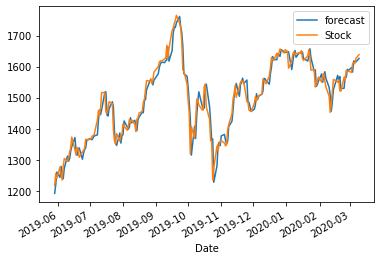

In [148]:
model = ARIMA(train_df, order=(2,1,7)).fit()
print(model.summary())
model.plot_predict();

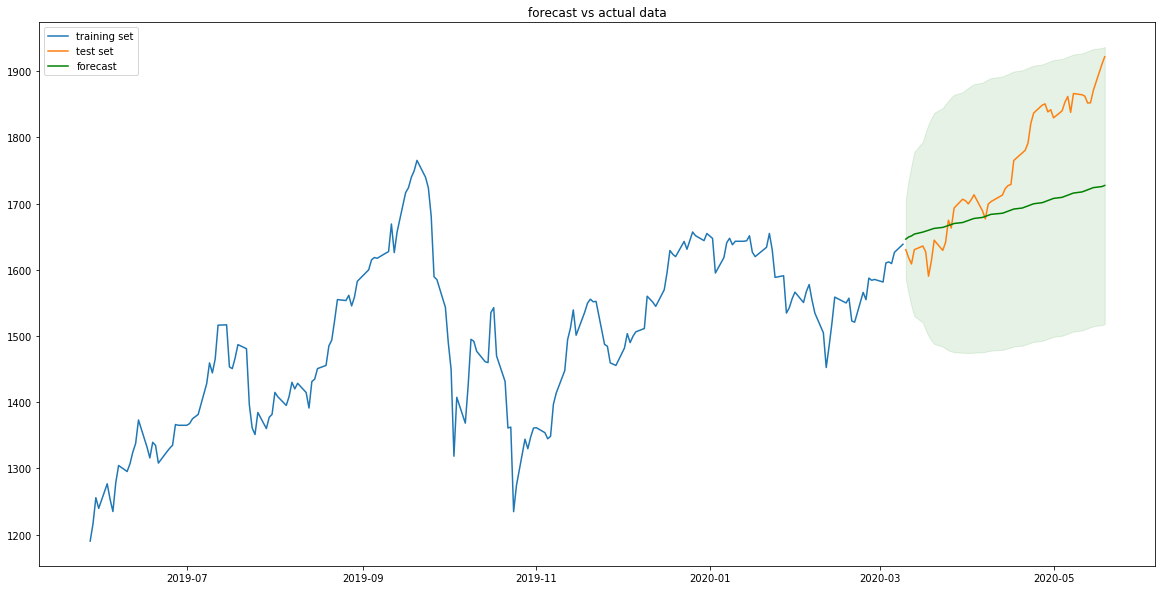

In [149]:
# forecast, standard error, 95% confidence interval
forecast, se, conf = model.forecast(50, alpha=0.05)  

fc_series = pd.Series(forecast, index=test_df.index)
lower_series = pd.Series(conf[:, 0], index=test_df.index)
upper_series = pd.Series(conf[:, 1], index=test_df.index)

plt.figure(figsize=(20,10))
plt.plot(train_df, label='training set')
plt.plot(test_df, label='test set')
plt.plot(fc_series, label='forecast', color='green')
plt.fill_between(lower_series.index, lower_series, upper_series, color='green', alpha=.1)
plt.title('forecast vs actual data')
plt.legend(loc='best')

In [150]:
e2 = (test_df.values - forecast)**2
rss = np.sum(e2)
rmse = np.mean(e2)**0.5
r2 = r2_score(test_df.values, forecast)

print('RSS: {}'.format(rss))
print('RMSE: {}'.format(rmse))
print('R^2: {}'.format(r2))


RSS: 33011400.07716901
RMSE: 114.91109620427265
R^2: -0.007572337688739328
